In [6]:
import jax.numpy as jnp
import immrax as irx
import numpy as np
from TVGPR import *
from GPR import *
import control

from functools import partial
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [7]:
# Some configurations
jax.config.update("jax_enable_x64", True)

# We wrap the jax.jit function t/o set the backend to cpu by default for convenience.
device = 'cpu'
def jit (*args, **kwargs):
    kwargs.setdefault('backend', device)
    return jax.jit(*args, **kwargs)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size": 14
})

np.random.seed(0)

# Planar Multirotor Dynamics as an Immrax System

In [8]:
# system dynamics and initial conditions
class PlanarMultirotorTransformed (irx.System) :
    def __init__ (self) :
        self.xlen = 5
        self.evolution = 'continuous'

    def f(self, t, x, u, w): #jax version of Eq.30 in "Trajectory Tracking Runtime Assurance for Systems with Partially Unknown Dynamics"
        px, py, h, v, theta = x.ravel()
        # u1, u2 = u.ravel()
        u1 = u[0]
        u2 = u[1]
        w1 = w[0]
        g = 9.81

        return jnp.array([
            h*jnp.cos(theta) - v*jnp.sin(theta),
            h*jnp.sin(theta) + v*jnp.cos(theta),
            -g*jnp.sin(theta) + w1*jnp.cos(theta),
            u1 - g*jnp.cos(theta) - w1*jnp.sin(theta),
            u2
        ])
    
    def f_np(self, t, x, u, w): # numpy version of Eq.30
        px, py, h, v, theta = x.ravel()
        u1 = u[0]
        u2 = u[1]
        w1 = w[0]
        g = 9.81

        return np.array([
            h*np.cos(theta) - v*np.sin(theta),
            h*np.sin(theta) + v*np.cos(theta),
            -g*np.sin(theta) + w1*np.cos(theta),
            u1 - g*np.cos(theta) - w1*np.sin(theta),
            u2
        ])

sys = PlanarMultirotorTransformed()

In [9]:
# Initial conditions
x0 = jnp.array([-4., 6., 0., 0., 0.1]) # [y=global horz direction, h=local horz direction,z=global vert direction,v=local vert direction,theta=roll angle between local and global frame]

u0 = jnp.array([9.81, 0.0]) # [u1=thrust, u2=roll angular rate]
w0 = jnp.array([0.0]) # [w1= unkown horizontal wind disturbance]

# Create intervals out of the initial conditions
x0_pert = jnp.array([0.01, 0.01, 0.01, 0.01, 0.01])
ix0 = irx.icentpert(x0, x0_pert)

# Input saturation interval -> -5 <= u1 <= 15, -5 <= u2 <= 5
ulim = irx.interval([-5, -5],[15, 5])

print(f"{x0=},\n{ix0= },\n{ulim=}")

x0=Array([-4. ,  6. ,  0. ,  0. ,  0.1], dtype=float64),
ix0= [-4.01  5.99 -0.01 -0.01  0.09] <= x <= [-3.99  6.01  0.01  0.01  0.11],
ulim=[-5 -5] <= x <= [15  5]


# Set up Gaussian Processes

In [10]:
GP_instantiation_values = jnp.array([[-2,-0.66005468347438],
                                    [0,1.71910828159421],
                                    [2,-2.73909534657961],
                                    [4,3.76474225408493],
                                    [6,3.65733558594356],
                                    [8,-0.116994810217270],
                                    [10,2.40224375111040],
                                    [12,-2.86490929098228]]) # at heights of y in the first column, disturbance to the values in the second column

# add a time dimension at t=0 to the GP instantiation values for TVGPR instantiation
actual_disturbance_GP = TVGPR(jnp.hstack((jnp.zeros((GP_instantiation_values.shape[0], 1)), GP_instantiation_values)), 
                                       sigma_f = 5.0, 
                                       l=2.0, 
                                       sigma_n = 0.01,
                                       epsilon=0.1,
                                       discrete=False
                                       )


def actual_disturbance_test(t, x) :
    return actual_disturbance_GP.mean(jnp.array([t, x[1]])).reshape(-1)

#sanity check: these should be the same if TVGPR discrete = false
test_actual = actual_disturbance_test(0.0, x0)

print("Current drone height:", x0[1])
print(f"{test_actual=}")

assert np.allclose(test_actual, GP_instantiation_values[4,1], rtol=1e-4), f"TVGPR test failed, expected {GP_instantiation_values[4,1]} but got {test_actual}"

Current drone height: 6.0
test_actual=Array([3.65728629], dtype=float64)


# Test The Gaussian Process

In [11]:
# Create an observation matrix with the disturbance at the current height
# This is a 9x3 matrix where each row is [t=0, y=current_height=x0[1], d=disturbance(t,y)]
# This is used to test the TVGPR model by giving it only instantiation values at t0=0 h0=6
# and predicing the disturbance at the same height but at t=10
n_obs = 9
obs = jnp.tile(jnp.array([[0, x0[1], actual_disturbance_test(0.0, x0)[0]]]),(n_obs,1))

testGPR = TVGPR(obs)
def test_disturbance(t, x):
    # This will predict the disturbance at t=10 and the current height x[1]
    time_height = jnp.array((10.0, x[1]))
    return testGPR.mean(time_height).reshape(-1)
print(f"{test_disturbance(0, x0)=}")

test_disturbance(0, x0)=Array([2.15959084], dtype=float64)


In [12]:
test_mjacM = irx.mjacM(test_disturbance) # create a mixed Jacobian inclusion matrix for the test disturbance function
test_perm = irx.Permutation((0, 1, 2, 4, 5, 3)) # This permutation allows for tighter embedding systems by moving through the state variables via the system axes in a specific order rather than by considering the entire state space

print(f"Initial state interval defined above: {ix0}")  
TEST_MG = test_mjacM(irx.interval(jnp.array([0.])), #give it the time interval (in this case just [0,0])
                     ix0, # give it the initial state interval 
                     centers=((jnp.array([0.]), x0,),), #give it the centers of the state and time intervals
                     permutations=(test_perm,)) # give it the permutations we want for the inclusion system calculation
print(TEST_MG)

Initial state interval defined above: [[(-4.01, -3.99)]
 [( 5.99,  6.01)]
 [(-0.01,  0.01)]
 [(-0.01,  0.01)]
 [( 0.09,  0.11)]]
[[Array([[0.]], dtype=float64), [[ 0.         -0.02159591  0.          0.          0.        ]] <= x <= [[0.         0.02159591 0.         0.         0.        ]]]]


# Now we set up the system that defines the reference trajectory

#### We use a standard planar quad linearization A and B with Q and R that prioritize reaching system origin

#### This K is what we use on a 'nominal'/'reference' planar quad system that generates what the reference states will look like using K as a feedback regulator for the A,B quad system

In [13]:
A = jnp.array([[0, 0, 1, 0, 0], 
               [0, 0, 0, 1, 0], 
               [0, 0, 0, 0, -9.81], 
               [0, 0, 0, 0, 0], 
               [0, 0, 0, 0, 0]])
B = jnp.array([[0, 0], 
               [0, 0], 
               [0, 0], 
               [1, 0], 
               [0, 1]])
Q = jnp.array([1000, 20, 500, 500, 1]) * jnp.eye(sys.xlen) # Different weights that prioritize reference reaching origin
R = jnp.array([20, 20]) * jnp.eye(2)
K, P, _ = control.lqr(A, B, Q, R)
reference_K = -1 * K
print(f"{reference_K=}")


reference_K=array([[ -0.        ,  -1.        ,  -0.        ,  -5.19615242,
         -0.        ],
       [  7.07106781,  -0.        ,   6.4170833 ,  -0.        ,
        -11.22288618]])


# We use LQR again to find the K value for the true system's linearization to track the reference

In [14]:
# Linearize previously instantiated PlanarMultirotorTransformed (sys.f) system around x0, u0 to compute LQR K for TRACKING REFERENCE
A, B = jax.jacfwd(lambda x: sys.f(0, x, u0, [0]))(x0), jax.jacfwd(lambda u: sys.f(0, x0, u, [0]))(u0)
# LQR Weight Matrices
Q = jnp.array([1, 1, 1, 1, 1]) * jnp.eye(sys.xlen) # weights that prioritize overall tracking of the reference (defined below)
R = jnp.array([1, 1]) * jnp.eye(2)
# Call LQR to get initial K, P
K, P, _ = control.lqr(A, B, Q, R)
feedback_K = -1 * K
print(f"{feedback_K=}\n")


feedback_K=array([[ 0.03762342, -0.99929199, -0.12853876, -1.72950908, -0.07007061],
       [ 0.99929199,  0.03762342,  1.45085207, -0.07007061, -5.42732413]])



# We define variables for the reachability rollout and the rollout function

In [15]:
t0 = 0.     # Initial time
dt = 0.01  # Time step
T = 30.0   # Reachable tube horizon
tt = jnp.arange(t0, T+dt, dt)

sys_mjacM = irx.mjacM(sys.f) # create a mixed Jacobian inclusion matrix for the system dynamics function
sys_jacM = irx.jacM(sys.f) # create a standard Jacobian matrix for the system dynamics function
perm = irx.Permutation((0, 1, 2, 3, 4, 5, 6, 7, 8)) # create a permutation for the inclusion system calculation

In [16]:
@jit
def rollout (t_init, ix, xc, K_feed, K_reference, obs) :
    def mean_disturbance (t, x) :
            return GP.mean(jnp.hstack((t, x[1]))).reshape(-1)    

    def sigma(t, x):
        return jnp.sqrt(GP.variance(jnp.hstack((t, x[1]))).reshape(-1))

    def sigma_bruteforce_if(t, ix):
        div = 100
        x_list = [ix.lower + ((ix.upper - ix.lower)/div)*i for i in range(div)]
        sigma_list = 3.0*jnp.array([sigma(t, x) for x in x_list]) # # TODO: get someone to explain: why 3.0?
        return irx.interval(jnp.array([jnp.min(sigma_list)]), jnp.array([jnp.max(sigma_list)]))
        
    def step (carry, t) :
        xt_emb, xt_ref, MS = carry
        
        u_reference = (K_reference @ xt_ref) + jnp.array([9.81, 0.0]) # get the reference input from the linearized planar quad LQR feedback K and current state
        u_ref_clipped = jnp.clip(u_reference, ulim.lower, ulim.upper) # clip the reference input to the input saturation limits


        # GP Interval Work
        GP_mean_t = GP.mean(jnp.array([t, xt_ref[1]])).reshape(-1) # get the mean of the disturbance at the current time and height
        xint = irx.ut2i(xt_emb) # buffer sampled sigma bound with lipschitz constant to recover guarantee
        x_div = (xint.upper - xint.lower)/(100*2) # x_div is 
        sigma_lip = MS @ x_div.T # Lipschitz constant for sigma function above
        w_diff = sigma_bruteforce_if(t, irx.ut2i(xt_emb)) # TODO: Explain
        w_diffint = irx.icentpert(0.0, w_diff.upper + sigma_lip.upper[1]) # TODO: Explain
        wint = irx.interval(GP_mean_t) + w_diffint

        
        # Compute the mixed Jacobian inclusion matrix for the system dynamics function and the disturbance function
        Mt, Mx, Mu, Mw = sys_mjacM( irx.interval(t), irx.ut2i(xt_emb), ulim, wint,
                                    centers=((jnp.array([t]), xt_ref, u_ref_clipped, GP_mean_t),), 
                                    permutations=(perm,))[0]
        
        _, MG = G_mjacM(irx.interval(jnp.array([t])), irx.ut2i(xt_emb), 
                        centers=((jnp.array([t]), xt_ref,),), 
                        permutations=(G_perm,))[0]
        Mt = irx.interval(Mt)
        Mx = irx.interval(Mx)
        Mu = irx.interval(Mu)
        Mw = irx.interval(Mw)

        

        # Embedding system for reachable tube overapproximation due to state/input/disturbance uncertainty around the sys.f reference system under K_ref
        F = lambda t, x, u, w: (Mx + Mu@K_feed + Mw@MG)@(x - xt_ref) + Mw@w_diffint + sys.f(0., xt_ref, u_ref_clipped, GP_mean_t) # with GP Jac
        embsys = irx.ifemb(sys, F)
        xt_emb_p1 = xt_emb + dt*embsys.E(irx.interval(jnp.array([t])), xt_emb, u_ref_clipped, wint)

        # Move the reference forward in time as well
        xt_ref_p1 = xt_ref + dt*sys.f(t, xt_ref, u_ref_clipped, GP_mean_t)

        
        return ((xt_emb_p1, xt_ref_p1, MS), (xt_emb_p1, xt_ref_p1, u_ref_clipped))
    


    GP = TVGPR(obs, sigma_f = 5.0, l=2.0, sigma_n = 0.01, epsilon = 0.25) # define the GP model for the disturbance
    tt = jnp.arange(0, T, dt) + t_init # define the time horizon for the rollout
    MS0 = jax.jacfwd(sigma, argnums=(1,))(t_init, xc)[0] #TODO: Explain

    G_mjacM = irx.mjacM(mean_disturbance) # TODO: Explain
    G_perm = irx.Permutation((0, 1, 2, 4, 5, 3))

    _, xx = jax.lax.scan(step, (irx.i2ut(ix), xc, irx.interval(MS0)), tt) #TODO: change variable names to be more descriptive
    return jnp.vstack((irx.i2ut(ix), xx[0])), jnp.vstack((xc, xx[1])), jnp.vstack(xx[2]) #TODO: change variable names to be more descriptive

xx, xxnom, unom_arr = rollout(0.0, ix0, x0, feedback_K, reference_K, obs)

In [17]:
print(xx.shape)
print(xxnom.shape)
print(unom_arr.shape)

(3001, 10)
(3001, 5)
(3000, 2)


# Now that its jitted it should run fast

In [18]:
xx, xxnom, unom_arr= rollout(0.0, ix0, x0, feedback_K, reference_K, obs)

In [19]:
# see how long 100 iterations take
%timeit -n1 -r100 rollout(0.0, ix0, x0, feedback_K, reference_K, obs) # uncomment to see the time it takes to run the rollout function

The slowest run took 2673.21 times longer than the fastest. This could mean that an intermediate result is being cached.
58.2 ms ± 38.2 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)


# Take the reachable tube and determine at which time step our safety is violated

In [20]:
# feed it ref and emb -> gives you 
def collection_id(xref, xemb, threshold=0.3):
    for i in range(xref.shape[0]):

        if any(np.abs(xref[i, :] - xemb[i, :5]) > threshold) or any(np.abs(xref[i, :] - xemb[i, 5:]) > threshold) or any(np.isnan(xref[i, :])) or any(np.isnan(xemb[i, :5])) or any(np.isnan(xemb[i, :])):
            return i
    return -1

collection_id(xxnom, xx)

30

# Set Up Planar Quad plotting function

In [21]:
def quadplot(xpos,ypos,rot,scale):
    ts=-.5*np.arange(np.pi,3/2*np.pi,.2)+.3
    xtemp=np.cos(ts)
    ytemp=np.sin(ts)*np.cos(ts)

    xs=np.hstack((.4*xtemp-1,-1,-1,1,1,.4*xtemp+1))
    ys=np.hstack((.3*ytemp+.4,.4,0,0,.4,.3*ytemp+.4))
    xs=scale*xs
    ys=scale*ys
    rotmat=np.array([[np.cos(rot),-np.sin(rot)],[np.sin(rot),np.cos(rot)]])
    # print(xs)
    newpos=rotmat@np.vstack((xs,ys))
    xs=newpos[0,:]+xpos
    ys=newpos[1,:]+ypos
    return xs,ys

quadplot(0, 0, 0, 1)

(array([-0.88179192, -0.92053227, -0.96006663, -1.        , -1.03993337,
        -1.07946773, -1.11820808, -1.15576734, -1.        , -1.        ,
         1.        ,  1.        ,  1.11820808,  1.07946773,  1.03993337,
         1.        ,  0.96006663,  0.92053227,  0.88179192,  0.84423266]),
 array([0.31530363, 0.34158725, 0.3701996 , 0.4       , 0.4298004 ,
        0.45841275, 0.48469637, 0.50760341, 0.4       , 0.        ,
        0.        , 0.4       , 0.31530363, 0.34158725, 0.3701996 ,
        0.4       , 0.4298004 , 0.45841275, 0.48469637, 0.50760341]))

# Set up the plotting/saving of gif/etc. The .gif if being generated as the system runs (hence why some of this is done in numpy)

In [22]:
# RUN SIMULATION AND SAVE ANIMATION
import matplotlib.animation as animation
import tikzplotlib
 
from matplotlib.lines import Line2D
from matplotlib.legend import Legend
 
Line2D._us_dashSeq    = property(lambda self: self._dash_pattern[1])
Line2D._us_dashOffset = property(lambda self: self._dash_pattern[0])
Legend._ncol = property(lambda self: self._ncols)
 

#### Finish setting up simulation variables and final functions

In [23]:
def u_applied(x, xref, uref, K_feedback):
    ubackup = (K_feedback @ (xref - x)) + uref
    unomt = np.array([np.minimum(np.maximum(ubackup[0], ulim.lower[0]), ulim.upper[0]),
            np.minimum(np.maximum(ubackup[1], ulim.lower[1]), ulim.upper[1])])
    return unomt
 
 
current_state = x0
current_int = irx.icentpert(current_state, x0_pert)
current_time = 0.0
traj_idx = 0
sim_dt = 0.05
sim_length = 16.0
thresh = 0.3
 
 
# setup disturbance behavior
np.random.seed(0)
actual_disturbance_GP_f = GPR(jnp.array([[-2,-0.66005468347438],
                                       [0,1.71910828159421],
                                       [2,-2.73909534657961],
                                       [4,3.76474225408493],
                                       [6,3.65733558594356],
                                       [8,-0.116994810217270],
                                       [10,2.40224375111040],
                                       [12,-2.86490929098228],
                                       ]),
                                       sigma_f = 5.0,
                                       l=2.0,
                                       sigma_n = 0.01
                                       )
actual_disturbance_GP_g = GPR(jnp.array([[-2,2.80494480741922],
                                       [0,-1.65967058757266],
                                       [2,-2.21529178685802],
                                       [4,-2.41828274757721],
                                       [6,-0.976879063072681],
                                       [8,-2.89172701466510],
                                       [10,-3.91337304908981],
                                       [12,-3.33944976072828],
                                       ]),
                                        sigma_f = 5.0,
                                        l=2.0,
                                        sigma_n = 0.01,
                                        )
dist_f_time = 0.0
dist_update_mag = 1.5
 
def actual_disturbance (t, x, epsilon=0.25) :
    t_leftover = t % 1.0
    cur_val = actual_disturbance_GP_f.mean(jnp.array([x[1]])).reshape(-1)
    next_val = jnp.sqrt(1-epsilon)*actual_disturbance_GP_f.mean(jnp.array([x[1]])).reshape(-1) + jnp.sqrt(epsilon)*actual_disturbance_GP_g.mean(jnp.array([x[1]])).reshape(-1)
    return (1.0 - t_leftover)*cur_val + t_leftover*next_val
 
obs = jnp.array([[0., x0[1], actual_disturbance(0.0, x0)[0]],
                    [0., x0[1], actual_disturbance(0.0, x0)[0]],
                    [0., x0[1], actual_disturbance(0.0, x0)[0]],
                    [0., x0[1], actual_disturbance(0.0, x0)[0]],
                    [0., x0[1], actual_disturbance(0.0, x0)[0]],
                    [0., x0[1], actual_disturbance(0.0, x0)[0]],
                    [0., x0[1], actual_disturbance(0.0, x0)[0]],
                    [0., x0[1], actual_disturbance(0.0, x0)[0]],
                    [0., x0[1], actual_disturbance(0.0, x0)[0]]])
 
xx, xxnom, unom_arr = rollout(current_time, current_int, current_state, feedback_K, reference_K, obs)
t_arr = np.arange(current_time, current_time + T, dt)
t_index = collection_id(xxnom, xx, thresh)
collection_time = t_arr[t_index]
applied_input = u_applied(current_state, xxnom[traj_idx, :], unom_arr[traj_idx, :], feedback_K)
flight_path = np.array([x0])
 

# Set up plotting

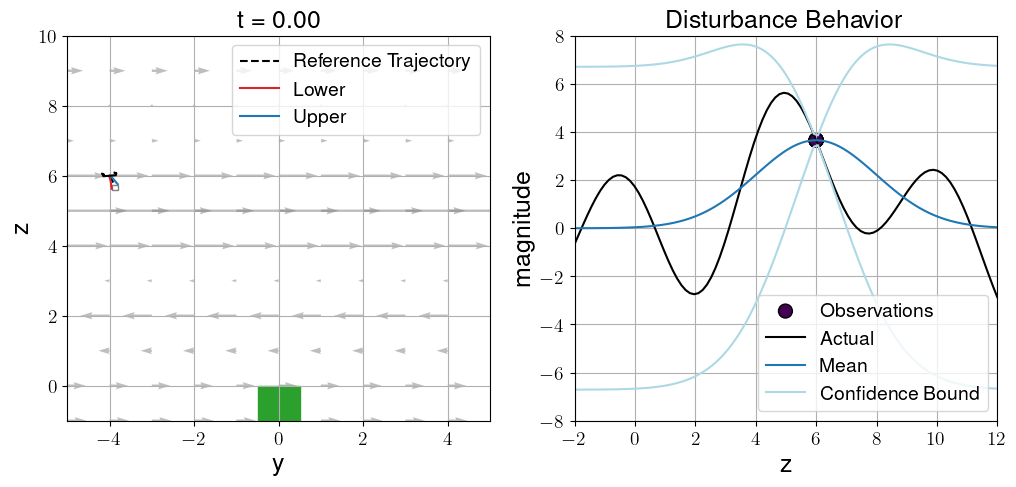

In [24]:
 
PLOT_OBS = True
SAVE_TIKZ = False # tikz export is not working in the document somehow so don't use this
SAVE_PDF = False
 
# PLOTTING
if PLOT_OBS:
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 5))
else:
    fig, ax = plt.subplots()
 
FONTSIZE = 18
LINEWIDTH = 1.5
QUADSIZE = 0.15
OBSSIZE = 100
SCATTERORDER = -1
if SAVE_PDF:
    FONTSIZE = 24
    LINEWIDTH = 3
    QUADSIZE = 0.25
    OBSSIZE = 200
    SCATTERORDER = 10
    
 
# # wind disturbance
arrow_points = np.mgrid[-5:5, -1:10].reshape(2, -1).T
arrow_dirs = arrow_points*0.0
for a in range(arrow_points.shape[0]):
    arrow_dirs[a, :] = [actual_disturbance(0.0, np.array([arrow_points[a, 0], arrow_points[a, 1], 0.0, 0.0, 0.0]))[0], 0.0]
wind_arrows = ax.quiver(arrow_points[:, 0], arrow_points[:, 1], arrow_dirs[:, 0], arrow_dirs[:, 1], color='tab:gray', alpha=0.5)
 
# mixed monotonicity tube
# t_index = int(t_star/dt)
t_index_plot = -2 if SAVE_PDF else t_index + 1 # plot up to deviation
nominal = ax.plot(xxnom[:t_index_plot,0], xxnom[:t_index_plot,1], label='Reference Trajectory', linestyle="dashed", color="black", linewidth=LINEWIDTH)[0]
lower = ax.plot(xx[:t_index_plot+1,0], xx[:t_index_plot+1,1], label='Lower', color="tab:red", linewidth=LINEWIDTH)[0]
upper = ax.plot(xx[:t_index_plot+1,5], xx[:t_index_plot+1,6], label='Upper', color = "tab:blue", linewidth=LINEWIDTH)[0]
 
# actual = ax.plot(xa[:t_index,0], xa[:t_index,1], label='Actual', linestyle="dashed")[0]
# flight = ax.plot(x0[0], x0[1], label='Flight Trajectory', color='black')[0]
 
start_rect = Rectangle((xx[0,0], xx[0,1]), xx[0,5] - xx[0,0], xx[0,6] - xx[0,1], linewidth=1, edgecolor='tab:gray', facecolor='none')
start_patch = ax.add_patch(start_rect)
# end_rect = Rectangle((xx[-1,0], xx[-1,1]), xx[-1,5] - xx[-1,0], xx[-1,6] - xx[-1,1], linewidth=1, edgecolor='tab:gray', facecolor='none', linestyle="dashed")
end_rect = Rectangle((xx[t_index_plot,0], xx[t_index_plot+1,1]), xx[t_index_plot+1,5] - xx[t_index_plot+1,0], xx[t_index_plot+1,6] - xx[t_index_plot+1,1], linewidth=1, edgecolor='tab:gray', facecolor='none')
end_patch = ax.add_patch(end_rect)
landing_rect = Rectangle((-0.5, -1.0), 1.0, 1.0, linewidth=1, edgecolor='tab:green', facecolor='tab:green')
ax.add_patch(landing_rect)
quad_x, quad_y = quadplot(x0[0], x0[1], x0[4], QUADSIZE)
quad = ax.plot(quad_x, quad_y, color='black', linewidth=LINEWIDTH)[0]
 
plt.axes(ax)
plt.xlabel('y', fontsize=FONTSIZE)
plt.ylabel('z', fontsize=FONTSIZE)
titletime = plt.title('t = %1.2f' % current_time, fontsize=FONTSIZE)
if not SAVE_PDF: plt.legend(loc ='upper right', fontsize=FONTSIZE - 4)
if not SAVE_PDF: plt.grid()
# plt.gca().set_aspect('equal')
plt.gca().set_xlim([-5, 5])
plt.gca().set_ylim([-1, 10])
 
if PLOT_OBS:
    gp_query_points = np.array([[0.0, p] for p in np.linspace(-2, 12, 100)])
    plotTVGP = TVGPR(obs, sigma_f = 5.0, l=2.0, sigma_n = 0.01, epsilon = 0.25)
    mean_pts = jnp.array([plotTVGP.mean(gpqp) for gpqp in gp_query_points]).reshape(-1)
    actual_pts = jnp.array([actual_disturbance(gpqp[0], jnp.array([0., gpqp[1], 0., 0., 0.]))[0] for gpqp in gp_query_points]).reshape(-1)
    sig_pts = 3*jnp.array([jnp.sqrt(plotTVGP.variance(gpqp)) for gpqp in gp_query_points]).reshape(-1)
    
    observations = ax2.scatter(obs[:, 1], obs[:, 2], label='Observations', c=obs[:, 0], cmap='viridis', s=OBSSIZE, edgecolors='black', zorder=SCATTERORDER)
    actual = ax2.plot(gp_query_points[:, 1], actual_pts, label='Actual', color='black', linewidth=LINEWIDTH)[0]
    mean = ax2.plot(gp_query_points[:, 1], mean_pts, label='Mean', color='tab:blue', linewidth=LINEWIDTH)[0]
    upper_conf = ax2.plot(gp_query_points[:, 1], mean_pts + sig_pts, label='Confidence Bound', color='lightblue', linewidth=LINEWIDTH)[0]
    lower_conf = ax2.plot(gp_query_points[:, 1], mean_pts - sig_pts, color='lightblue', linewidth=LINEWIDTH)[0]
 
 
    plt.axes(ax2)
    plt.xlabel('z', fontsize=FONTSIZE)
    plt.ylabel('magnitude', fontsize=FONTSIZE)
    plt.title('Disturbance Behavior', fontsize=FONTSIZE)
    if not SAVE_PDF: plt.legend(loc ='lower right', fontsize=FONTSIZE - 4)
    plt.grid()
    # plt.gca().set_aspect('equal')
    plt.gca().set_xlim([-2, 12])
    plt.gca().set_ylim([-8, 8])
 
if SAVE_TIKZ:
    plt.show()
    print("Saving tikz figure")
    tikzplotlib.clean_figure()
    filename = "tex/landing_sim_tvgp_withobs_ogdyn_simple_%1.2f.tex" % current_time
    tikzplotlib.save(filename, figure=fig)
 
if SAVE_PDF:
    # plt.show()
    print("Saving pdf figure")
    filename = "pdf/landing_sim_tvgp_withobs_ogdyn_%1.2f.pdf" % current_time
    plt.savefig(filename, format="pdf", bbox_inches="tight")


# This function updates the frame on the gif as it saves

In [25]:
def update(frame):
    # apply input, update state/time
    global current_state, applied_input, current_time, flight_path, collection_time, traj_idx, t_index, t_index_plot, obs, xxnom, xx, unom_arr, arrow_points, wind_arrows, actual_disturbance_GP_f, actual_disturbance_GP_g, dist_f_time, plotTVGP, mean, actual, PLOT_OBS, SAVE_TIKZ, observations, upper, lower, dist_update_mag, OBSSIZE
    print(f"{frame=}")
    print(f"{current_state=}")
    print(f"{applied_input=}")
    print(f"{current_time=}")
    print(f"{collection_time=}\n")

    for i in range(int(sim_dt/dt)):
        # while current_time < current_time + sim_dt:
        current_state = current_state + dt * sys.f_np(current_time, current_state, applied_input, actual_disturbance(current_time, current_state))
        flight_path = np.vstack((flight_path, current_state))
        current_int = irx.icentpert(current_state, x0_pert)
        current_time = current_time + dt
        traj_idx += 1
        
        # if current_time >= collection_time, collect new observation and recompute
        if current_time >= collection_time:
            obs = jnp.vstack((obs[1:, :], jnp.array([[current_time, current_state[1], actual_disturbance(current_time, current_state)[0]]])))
            if PLOT_OBS: plotTVGP = TVGPR(obs, sigma_f = 5.0, l=2.0, sigma_n = 0.01, epsilon = 0.25)
            # print(obs)
            xx, xxnom, unom_arr = rollout(current_time, current_int, current_state, feedback_K, reference_K, obs)
            # print(xx)
            t_arr = np.arange(current_time, current_time + T, dt)
            t_index = collection_id(xxnom, xx, thresh)
            t_index_plot = -2 if SAVE_PDF else t_index + 10
            collection_time = t_arr[t_index]    
            
            traj_idx = 0
 
        # if it's been 1 second, crete next portion of disturbance behavior
        if current_time >= dist_f_time + 1.0:
            dist_f_time = jnp.floor(current_time)
            actual_disturbance_GP_f = GPR(jnp.array([[-2, actual_disturbance(0.99, [0, -2])[0]],
                                       [0,actual_disturbance(0.99, [0, 0])[0]],
                                       [2,actual_disturbance(0.99, [0, 2])[0]],
                                       [4,actual_disturbance(0.99, [0, 4])[0]],
                                       [6,actual_disturbance(0.99, [0, 6])[0]],
                                       [8,actual_disturbance(0.99, [0, 8])[0]],
                                       [10,actual_disturbance(0.99, [0, 10])[0]],
                                       [12,actual_disturbance(0.99, [0, 12])[0]],
                                       ]),
                                       sigma_f = 5.0,
                                       l=2.0,
                                       sigma_n = 0.01
                                       )
            actual_disturbance_GP_g = GPR(jnp.array([[-2, np.random.normal(scale=dist_update_mag)],
                                        [0,np.random.normal(scale=dist_update_mag)],
                                        [2,np.random.normal(scale=dist_update_mag)],
                                        [4,np.random.normal(scale=dist_update_mag)],
                                        [6,np.random.normal(scale=dist_update_mag)],
                                        [8,np.random.normal(scale=dist_update_mag)],
                                        [10,np.random.normal(scale=dist_update_mag)],
                                        [12,np.random.normal(scale=dist_update_mag)],
                                        ]),
                                        sigma_f = 5.0,
                                        l=2.0,
                                        sigma_n = 0.01,
                                        )
            
 
        applied_input = u_applied(current_state, xxnom[traj_idx, :], unom_arr[traj_idx, :], feedback_K)
    # t_index = -1
    
    arrow_dirs = arrow_points*0.0
    for a in range(arrow_points.shape[0]):
        arrow_dirs[a, :] = [actual_disturbance(current_time, np.array([arrow_points[a, 0], arrow_points[a, 1], 0.0, 0.0, 0.0]))[0], 0.0]
    wind_arrows.set_UVC(arrow_dirs[:, 0], arrow_dirs[:, 1])
 
 
    nominal.set_data(xxnom[:,0], xxnom[:,1])
    lower.set_data(xx[:t_index_plot+1,0], xx[:t_index_plot+1,1])
    upper.set_data(xx[:t_index_plot+1,5], xx[:t_index_plot+1,6])
    
    quad_x, quad_y = quadplot(current_state[0], current_state[1], current_state[4], QUADSIZE)
    quad.set_data(quad_x, quad_y)
    # actual.set_data(xa[:t_index,0], xa[:t_index,1])
    # flight.set_data(flight_path[:,0], flight_path[:,1])
    start_patch.set_xy((xx[0,0], xx[0,1]))
    start_patch.set_width(xx[0,5] - xx[0,0])
    start_patch.set_height(xx[0,6] - xx[0,1])
    end_patch.set_xy((xx[t_index_plot+1,0], xx[t_index_plot+1,1]))
    end_patch.set_width(xx[t_index_plot+1,5] - xx[t_index_plot+1,0])
    end_patch.set_height(xx[t_index_plot+1,6] - xx[t_index_plot+1,1])
    
    titletime.set_text('t = %1.2f' % current_time)
 
    if PLOT_OBS:
        gp_query_points[:, 0] = current_time
        mean_pts = jnp.array([plotTVGP.mean(gpqp) for gpqp in gp_query_points]).reshape(-1)
        actual_pts = jnp.array([actual_disturbance(gpqp[0], jnp.array([0., gpqp[1], 0., 0., 0.]))[0] for gpqp in gp_query_points]).reshape(-1)
        sig_pts = 3*jnp.array([jnp.sqrt(plotTVGP.variance(gpqp)) for gpqp in gp_query_points]).reshape(-1)
        
        
        actual.set_data(gp_query_points[:, 1], actual_pts)
        mean.set_data(gp_query_points[:, 1], mean_pts)
        upper_conf.set_data(gp_query_points[:, 1], mean_pts + sig_pts)
        lower_conf.set_data(gp_query_points[:, 1], mean_pts - sig_pts)
        observations.set_offsets(obs[:, 1:])
        observations.set_sizes(OBSSIZE*jnp.exp(2*(obs[:, 0] - current_time)))
        if not SAVE_PDF: observations.set_alpha(jnp.exp(1.0*(obs[:, 0] - current_time)))
 
    if SAVE_TIKZ:
        if (frame+2) % 20 == 0:
            plt.show()
            print("Saving tikz figure")
            tikzplotlib.clean_figure()
            filename = "tex/landing_sim_tvgp_withobs_ogdyn_simple_%1.2f.tex" % current_time
            tikzplotlib.save(filename, figure=fig, axis_width=r'\figurewidth', axis_height=r'\figureheight', extra_axis_parameters=['legend style={font=\tiny}'])
    
    if SAVE_PDF:
        if (frame+2) % 20 == 0:
            # plt.show()
            print("Saving pdf figure")
            filename = "pdf/landing_sim_tvgp_withobs_ogdyn_%1.2f.pdf" % current_time
            plt.savefig(filename, format="pdf", bbox_inches="tight")
    
 
    return (nominal, lower, upper, quad, start_patch, end_patch, titletime)


In [ ]:
ani = animation.FuncAnimation(fig=fig, func=update, frames=int(sim_length/sim_dt), interval=int(sim_dt*1000))
ani.save(filename="rta_output5.gif", writer="pillow")

frame=0
current_state=Array([-4. ,  6. ,  0. ,  0. ,  0.1], dtype=float64)
applied_input=array([ 3.81, -5.  ])
current_time=0.0
collection_time=0.3

frame=0
current_state=Array([-3.99713859,  5.99400286,  0.18162241, -0.2683934 , -0.14999466],      dtype=float64)
applied_input=array([ 5.2105162 , -4.99958949])
current_time=0.05
collection_time=0.3

frame=1
current_state=Array([-3.9874462 ,  5.97383875,  0.47804753, -0.41872955, -0.39997344],      dtype=float64)
applied_input=array([ 6.01285725, -5.        ])
current_time=0.09999999999999999
collection_time=0.3

frame=2
current_state=Array([-3.97070379,  5.93915415,  0.87276728, -0.45317657, -0.64997344],      dtype=float64)
applied_input=array([ 6.23857443, -5.        ])
current_time=0.15
collection_time=0.3

frame=3
current_state=Array([-3.94709885,  5.8871472 ,  1.34247134, -0.37632595, -0.89997344],      dtype=float64)
applied_input=array([ 5.93454634, -5.        ])
current_time=0.20000000000000004
collection_time=0.3

frame=4
curre